# Practical Data Science Assignment-1
### Name: Dhanushraj Murugan
### Reg. No: F3352509

### Project Title: Greek Websites crawling and Term Detection Analysis

#### Part-A: Web Crawling

### Importing required libraries for Crawling

In [1]:
import asyncio
import aiohttp
from asyncio import Queue
from urllib.parse import urlparse, urljoin, urlunparse
from bs4 import BeautifulSoup
import re
import random
import pandas as pd
import urllib.robotparser
import os

### Cleaning the text using Regular Expressions

In [2]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.replace("\x00", "")
    text = re.sub(r"[\x01-\x1F\x7F]", " ", text)
    allowed_pattern = r"[^A-Za-z0-9\u0370-\u03FF\u1F00-\u1FFF\.\,\?\!\;\:\'\"\(\)\[\]\{\}\-\_/–—… ]+"
    text = re.sub(allowed_pattern, " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

### Performing Ethical Crawling using robotparser

In [3]:
robots_cache = {}

def allowed(url):
    parsed = urlparse(url)
    domain = f"{parsed.scheme}://{parsed.netloc}"
    if domain not in robots_cache:
        rp = urllib.robotparser.RobotFileParser()
        rp.set_url(domain + "/robots.txt")
        try:
            rp.read()
        except:
            robots_cache[domain] = None
            return True
        robots_cache[domain] = rp
    rp = robots_cache.get(domain)
    if rp is None:
        return True
    return rp.can_fetch("*", url)

### URL Normalization and Domain Check

In [4]:
def normalize_url(base, href):
    absolute = urljoin(base, href)
    parsed = urlparse(absolute)
    normalized = urlunparse((parsed.scheme, parsed.netloc, parsed.path, "", "", ""))
    return normalized.rstrip("/")

def is_allowed_domain(url, whitelist_domains=["gr"]):
    return any(urlparse(url).netloc.endswith(domain) for domain in whitelist_domains)

### Asynchronous Fetch (GET)

In [5]:
async def fetch(session, url):
    try:
        async with session.get(url, timeout=15, headers={"User-Agent": "CustomCrawler/1.0"}) as resp:
            if resp.status != 200:
                return None
            return await resp.text()
    except:
        return None

### Saving into CSV file function

In [ ]:
async def worker_csv_mem(name, queue: Queue, visited: set, session: aiohttp.ClientSession, max_depth, csv_file="new_scraped_greek_text.csv"):
    # Ensure CSV exists with headers
    if not os.path.exists(csv_file):
        pd.DataFrame(columns=["url", "timestamp", "text"]).to_csv(csv_file, index=False)

    while True:
        item = await queue.get()
        if item is None:
            queue.task_done()
            break

        url, depth = item
        if url in visited or depth > max_depth:
            queue.task_done()
            continue
        if not allowed(url) or not is_allowed_domain(url):
            queue.task_done()
            continue

        html = await fetch(session, url)
        if html is None:
            queue.task_done()
            continue

        visited.add(url)
        print(f"[{len(visited)}] Worker {name} visiting: {url} (depth={depth})")

        # Parse and clean text
        soup = BeautifulSoup(html, "lxml")
        text = soup.get_text(" ", strip=True)
        cleaned = clean_text(text)

        # Append directly to CSV with timestamp
        pd.DataFrame([{
            "url": url,
            "timestamp": pd.Timestamp.now(),
            "text": cleaned
        }]).to_csv(csv_file, mode="a", header=False, index=False)

        # Extract links
        for link in soup.find_all("a", href=True):
            href = link["href"]
            if not href.startswith("http"):
                href = normalize_url(url, href)
            if "gr" not in href:
                continue
            norm = normalize_url(url, href)
            if norm not in visited:
                await queue.put((norm, depth + 1))

        queue.task_done()
        await asyncio.sleep(random.uniform(0.1, 0.5))

### Asynchronous Crawler function

In [7]:
async def crawl_async_mem(seed_urls, max_depth=5, num_workers=100, csv_file="new_scraped_greek_text.csv"):
    visited = set()
    # If CSV exists and is non-empty, load visited URLs to resume
    if os.path.exists(csv_file) and os.path.getsize(csv_file) > 0:
        df = pd.read_csv(csv_file)
        visited = set(df["url"].tolist())
        print(f"Resuming crawl. Already visited {len(visited)} pages.")

    queue = Queue()
    for url in seed_urls:
        if url not in visited:
            await queue.put((url, 0))

    async with aiohttp.ClientSession() as session:
        tasks = []
        for i in range(num_workers):
            task = asyncio.create_task(worker_csv_mem(f"W{i+1}", queue, visited, session, max_depth, csv_file))
            tasks.append(task)

        await queue.join()

        # Stop workers
        for _ in range(num_workers):
            await queue.put(None)
        await asyncio.gather(*tasks)

    print(f"✅ Crawling finished. Total pages visited: {len(visited)}")

### Urls used and running the crawler

In [ ]:
seed_urls = [
    "https://www.capital.gr/",
    "https://www.euro2day.gr/",
    "https://www.ekathimerini.com",
    "https://greekreporter.com",
    "https://www.businessnews.gr/epixeiriseis",
    "https://en.protothema.gr",
    "https://www.keeptalkinggreece.com",
    "https://news.gtp.gr",
    "https://capitallink.com/",
    "https://greekcitytimes.com/"
]

# Run async crawler

#await crawl_async_mem(seed_urls, max_depth=5, num_workers=100)

### Importing Libraries required for NLP

In [9]:
import time
import numpy as np
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords

import unicodedata
import spacy
from collections import defaultdict
from rapidfuzz import fuzz      # Much faster than fuzzywuzzy
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import community  # Louvain

import squarify

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the Scraped Greek text csv file

In [10]:
csv_file = "new_scraped_greek_text.csv"

# Read the file with no header
df = pd.read_csv(csv_file, header=None, names=["url", "timestamp", "text"])

# Save it back WITH headers
df.to_csv(csv_file, index=False)

In [11]:
df.head()

,url,timestamp,text
0,url,timestamp,text
1,url,timestamp,text
2,url,timestamp,text
3,url,timestamp,text
4,https://www.capital.gr/,2025-11-20 13:16:04.837599,Ειδήσεις νέα για την οικονομία την πολιτική απ...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44264 entries, 0 to 44263
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        44264 non-null  object
 1   timestamp  44264 non-null  object
 2   text       44240 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


## Part-2 Data Processing and Visualization

### Preprocessed Greek terms provided (confidential)

In [13]:
# Load Excel with multiple columns
terms_df = pd.read_csv("greek_terms_dataset.csv", on_bad_lines="skip")

# Convert into dictionary: {category: [terms]}
categories = defaultdict(list)

for col in terms_df.columns:
    col_terms = terms_df[col].dropna().astype(str).tolist()
    categories[col] = col_terms

In [14]:
terms_df.head()

,Περιοχή επενδυτών,Red-flags και φράσεις,Κρυπτο-υπηρεσίες
0,σταθερή απόδοση/profit,περιορισμένος χρόνος / limited time offer,presale / ICO / token sale
1,επενδυτική πρόταση,προσφορά μόνο για σήμερα / only today,liquidity mining / guaranteed APR (Annual Perc...
2,εγγυημένο κέρδος/απόδοση,πρώτοι 100 επενδυτές / limited slots,token airdrop (όταν ζητούνται κλειδιά/κατάθεση)
3,καθημερινή πληρωμή / (daily payouts),κάποια ειδική προσφορά για εσάς,private sale / seed round
4,εξασφαλισμένη αξία,άμεσα αποτελέσματα / επιστροφή / κατάθεση τώρα,Bridge / wrapping service with fees


In [15]:
terms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Περιοχή επενδυτών      135 non-null    object
 1   Red-flags και φράσεις  135 non-null    object
 2   Κρυπτο-υπηρεσίες       135 non-null    object
dtypes: object(3)
memory usage: 3.3+ KB


In [16]:
#!python -m spacy download el_core_news_sm

### Greek NLP Setup

In [17]:
nlp = spacy.load("el_core_news_sm")

In [18]:
NORMALIZE_CACHE = {}
LEMMA_CACHE = {}

#### 1. Fast Greek normalization with caching

In [ ]:

def normalize_greek(text):
    if not isinstance(text, str):
        return ""

    if text in NORMALIZE_CACHE:
        return NORMALIZE_CACHE[text]

    t = unicodedata.normalize("NFD", text)
    t = "".join(c for c in t if not unicodedata.combining(c))
    t = t.lower()
    t = re.sub(r"[^\w\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()

    NORMALIZE_CACHE[text] = t
    return t

#### 2. Lemmatization lookup

In [ ]:

def cached_lemma(word):
    if word in LEMMA_CACHE:
        return LEMMA_CACHE[word]

    doc = nlp(word)
    lemma = doc[0].lemma_
    LEMMA_CACHE[word] = lemma
    return lemma

#### 3. Variants in the text

In [ ]:

def expand_slash_variants(term):
    if "/" in term:
        return [t.strip() for t in term.split("/") if t.strip()]
    return [term]

#### 4. Text Preprocessing

In [ ]:

def preprocess_text(text):
    normalized = normalize_greek(text)
    words = normalized.split()

    # cached lemma for each word
    lemmas = [cached_lemma(w) for w in words]

    return normalized, words, lemmas


#### 5. Term Matching

In [ ]:

def match_single_term(term, normalized_text, words, lemmas):
    term_norm = normalize_greek(term)
    if not term_norm:
        return False

    # cached lemma for term
    term_lemma = cached_lemma(term_norm)

    # 1. Direct substring
    if term_norm in normalized_text:
        return True

    # 2. Lemma match
    if term_lemma in lemmas:
        return True

    # 3. RapidFuzz word match (super fast)
    if len(term_norm) >= 4:
        for w in words:
            if fuzz.partial_ratio(term_norm, w) >= 80:
                return True

    # 4. RapidFuzz phrase match (slower)
    if len(normalized_text) <= 200:
        if fuzz.partial_ratio(term_norm, normalized_text) >= 85:
            return True

    return False



#### 6. Multiple Terms Handler

In [ ]:

def match_term(term, normalized_text, words, lemmas):
    for variant in expand_slash_variants(term):
        if match_single_term(variant, normalized_text, words, lemmas):
            return True
    return False


#### 7. Detection of Categories for the terms

In [ ]:

# 7. Detect categories
def detect_terms(text, categories):
    found = defaultdict(list)
    normalized_text, words, lemmas = preprocess_text(text)

    for category, term_list in categories.items():
        for term in term_list:
            if match_term(term, normalized_text, words, lemmas):
                found[category].append(term)

    return found

#### 8. Saving to Results_df csv

In [ ]:

# 8. Build results_df with safe progress logs

results = []

for i, row in df.iterrows():
    detected = detect_terms(row["text"], categories)

    results.append({
        "timestamp": row["timestamp"],
        "url": row["url"],
        "counts": {cat: len(set(detected[cat])) for cat in categories}
    })

    # SAFE PROGRESS LOGGING
    if i % 500 == 0:
        print(f"[INFO] Processed {i} rows...")

# Save results
results_df = pd.DataFrame(results)
results_df.to_pickle("results.pkl")

[INFO] Processed 0 rows...
[INFO] Processed 500 rows...
[INFO] Processed 1000 rows...
[INFO] Processed 1500 rows...
[INFO] Processed 2000 rows...
[INFO] Processed 2500 rows...
[INFO] Processed 3000 rows...
[INFO] Processed 3500 rows...
[INFO] Processed 4000 rows...
[INFO] Processed 4500 rows...
[INFO] Processed 5000 rows...
[INFO] Processed 5500 rows...
[INFO] Processed 6000 rows...
[INFO] Processed 6500 rows...
[INFO] Processed 7000 rows...
[INFO] Processed 7500 rows...
[INFO] Processed 8000 rows...
[INFO] Processed 8500 rows...
[INFO] Processed 9000 rows...
[INFO] Processed 9500 rows...
[INFO] Processed 10000 rows...
[INFO] Processed 10500 rows...
[INFO] Processed 11000 rows...
[INFO] Processed 11500 rows...
[INFO] Processed 12000 rows...
[INFO] Processed 12500 rows...
[INFO] Processed 13000 rows...
[INFO] Processed 13500 rows...
[INFO] Processed 14000 rows...
[INFO] Processed 14500 rows...
[INFO] Processed 15000 rows...
[INFO] Processed 15500 rows...
[INFO] Processed 16000 rows...
[

#### Loading the pickle file

It contains the results of the NLP pipeline

In [53]:
results_df = pd.read_pickle("results.pkl")

In [54]:
expanded = pd.concat(
    [results_df.drop(["counts"], axis=1),
     results_df["counts"].apply(pd.Series)],
    axis=1
)

### Term Trends Over Time

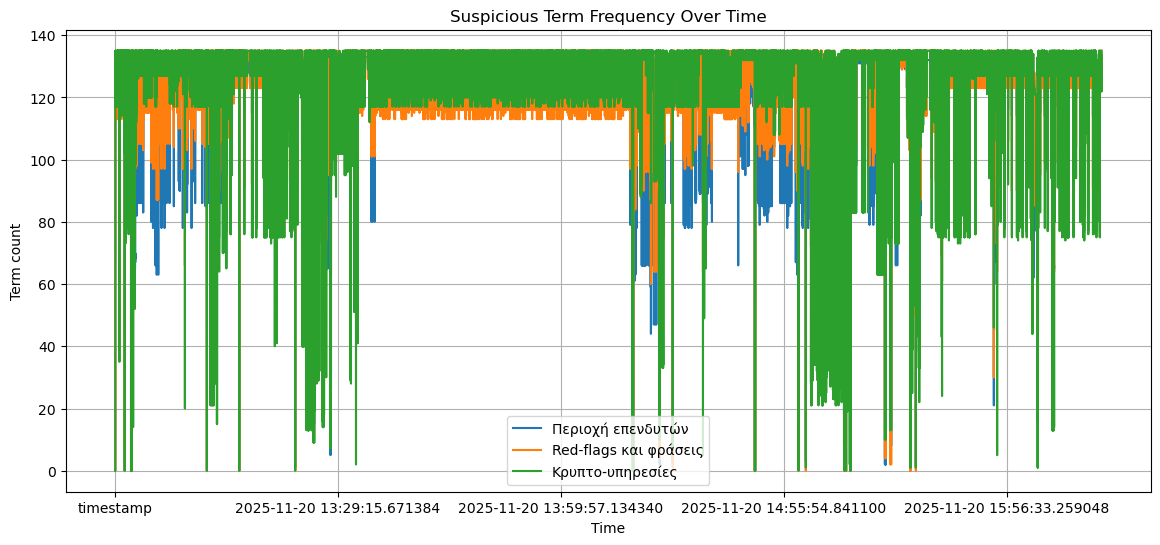

In [55]:
expanded.set_index("timestamp")[categories.keys()].plot(figsize=(14, 6))
plt.title("Suspicious Term Frequency Over Time")
plt.ylabel("Term count")
plt.xlabel("Time")
plt.grid(True)
plt.show()

#### Token Analysis

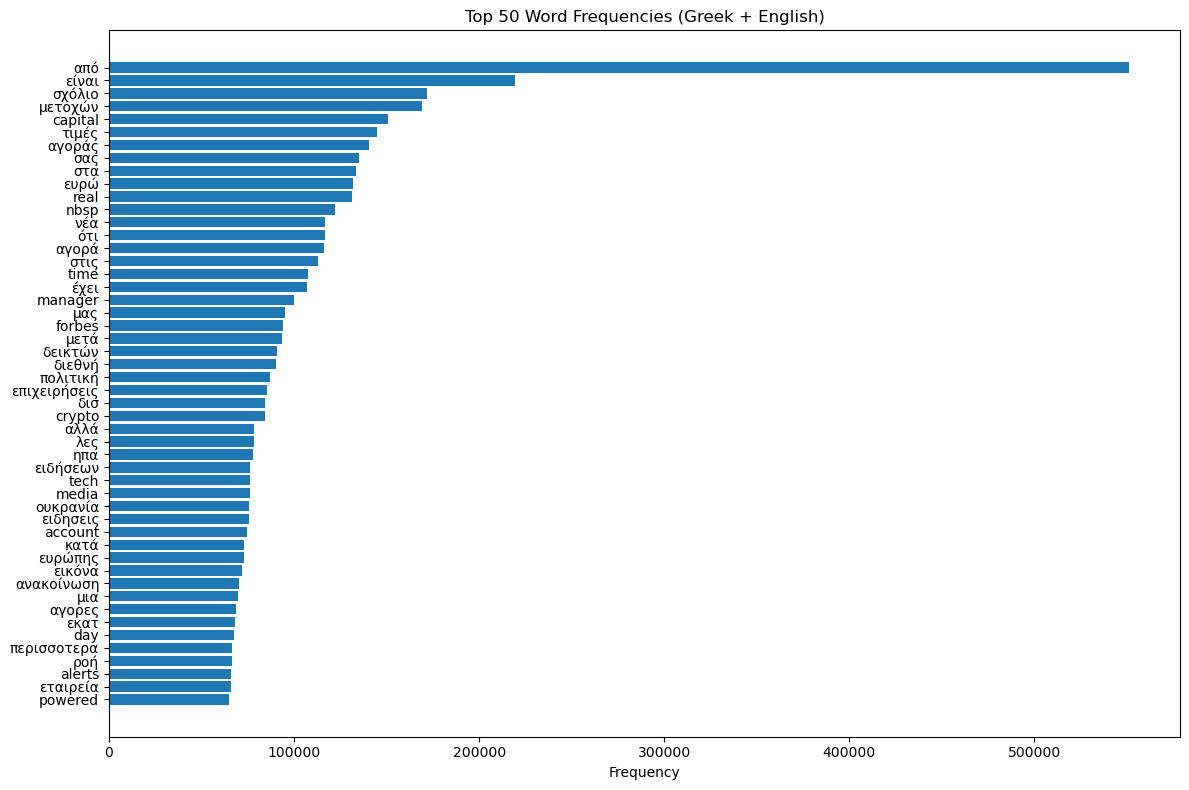

In [62]:
greek_stop = set(stopwords.words('greek'))
english_stop = set(stopwords.words('english'))
greek_stop = {normalize_greek(w) for w in greek_stop}
english_stop = {normalize_greek(w) for w in english_stop}
all_stop = greek_stop | english_stop

def tokenize(text):
    return [w.lower() for w in re.findall(r"[a-zA-Zα-ωΑ-Ωάέήίύόώϊϋΐΰ]+", text)]

# ---- Automatic PDF noise filtering ----
PDF_NOISE_PATTERNS = [
    r"^[a-f0-9]{8,}$",          
    r"^[a-f0-9]{4}-[a-f0-9]{4}",
    r"^(obj|endobj|xref|trailer|startxref)$",
    r"^(adobe|xmp|xap|pdf|indesign|aeb|metadata)$",
    r"^(uuid|iid|documentid|instanceid)$",
    r"^(bytes|stream|filter|length)$",
]

PDF_NOISE_REGEX = re.compile("|".join(PDF_NOISE_PATTERNS))

def is_noise(word: str) -> bool:
    return PDF_NOISE_REGEX.search(word) is not None

df["text"] = df["text"].fillna("").astype(str)

# ---- Word extraction ----
all_words = []

for text in df["text"]:
    words = tokenize(text)
    words = [
        w for w in words
        if w not in all_stop
        and len(w) > 2
        and not is_noise(w)
    ]
    all_words.extend(words)

freq = Counter(all_words).most_common(50)
freq[:10]

words, counts = zip(*freq)

plt.figure(figsize=(12, 8))
plt.barh(words, counts)
plt.gca().invert_yaxis()   # Most frequent at the top
plt.xlabel("Frequency")
plt.title("Top 50 Word Frequencies (Greek + English)")
plt.tight_layout()
plt.show()

#### Token Treemap

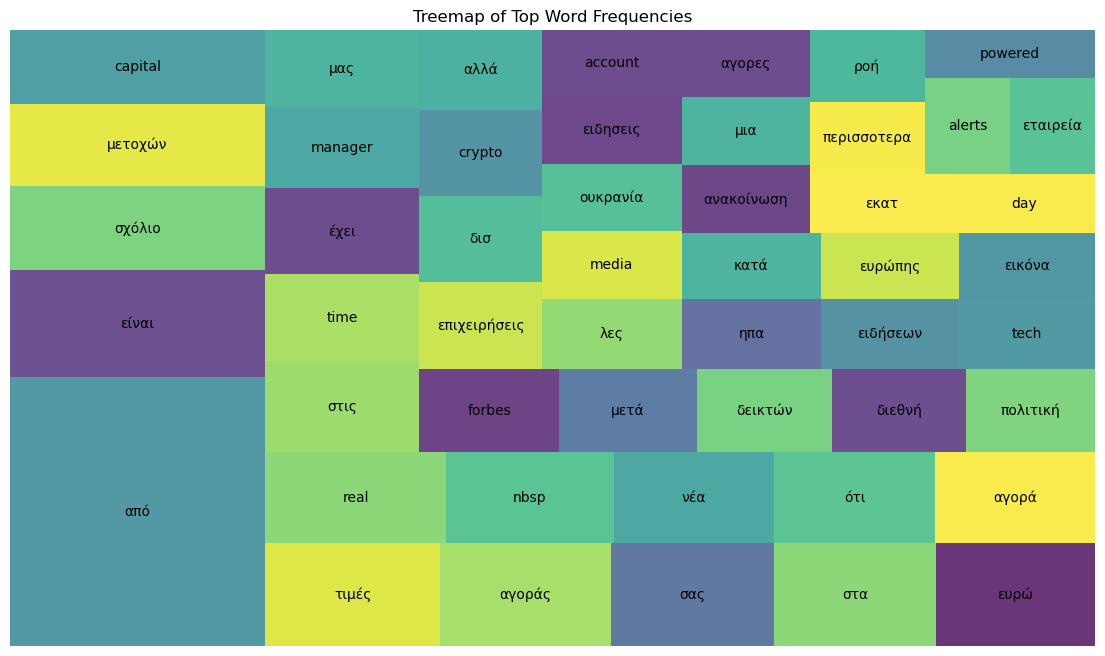

In [64]:
words, counts = zip(*freq)

plt.figure(figsize=(14, 8))
squarify.plot(
    sizes=counts,
    label=words,
    alpha=0.8
)
plt.title("Treemap of Top Word Frequencies")
plt.axis("off")
plt.show()

#### Word Cloud of all possible words

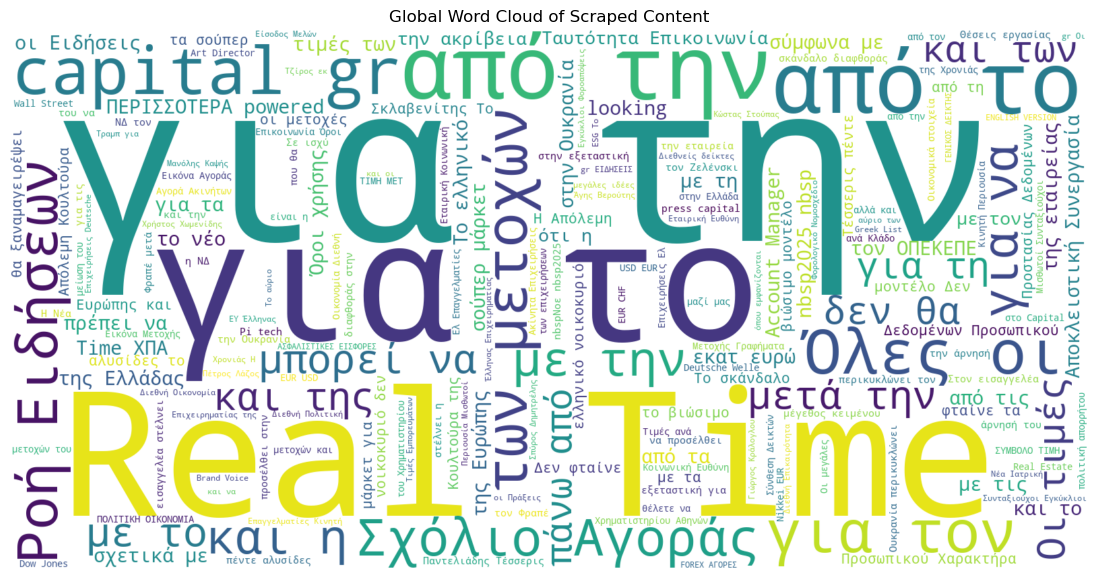

In [66]:
# Global word cloud
text_all = " ".join(df["text"])

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text_all)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Global Word Cloud of Scraped Content")
plt.show()

#### Word Cloud for each Category

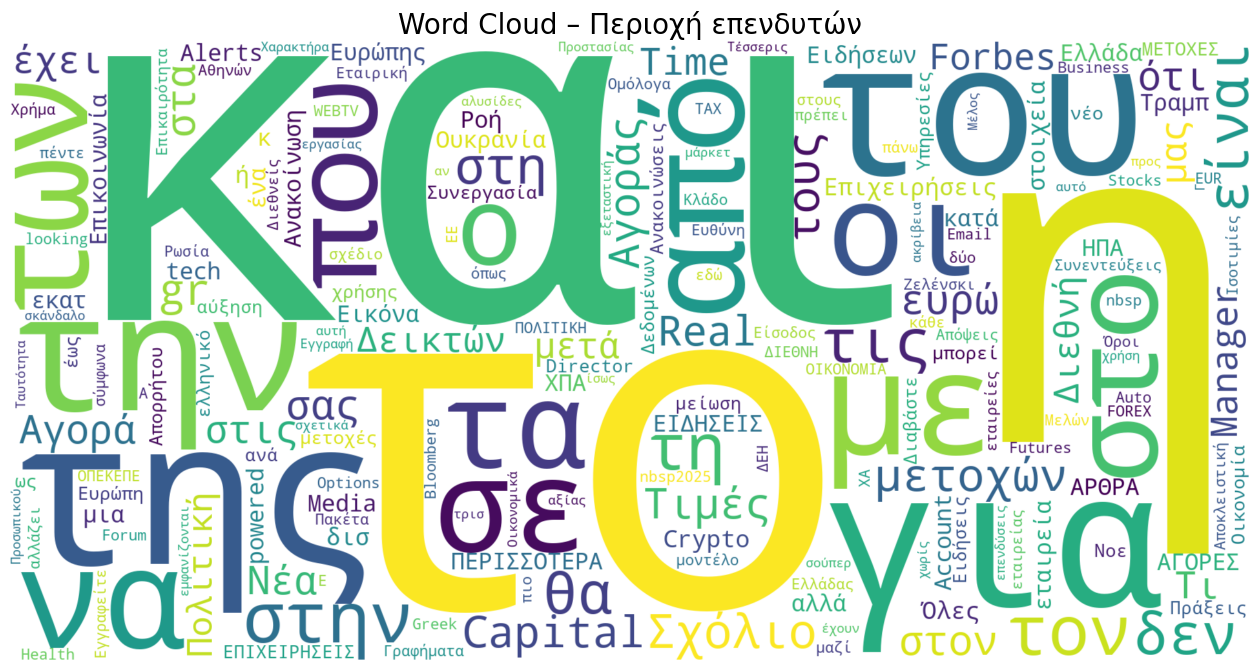

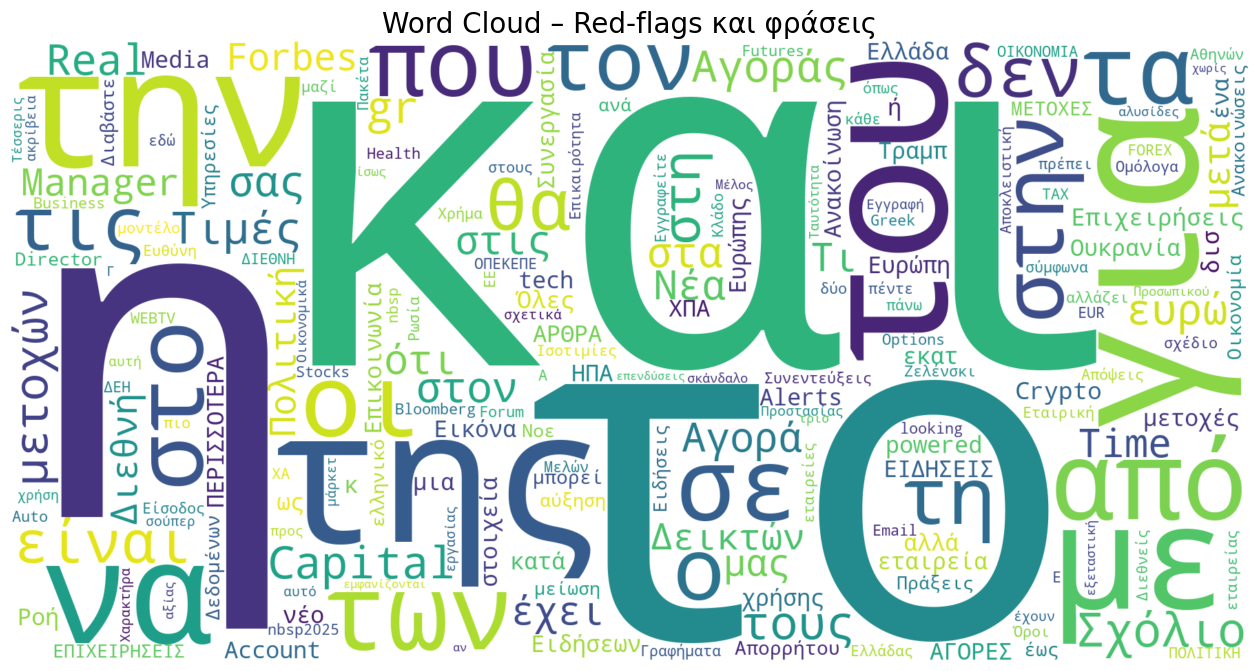

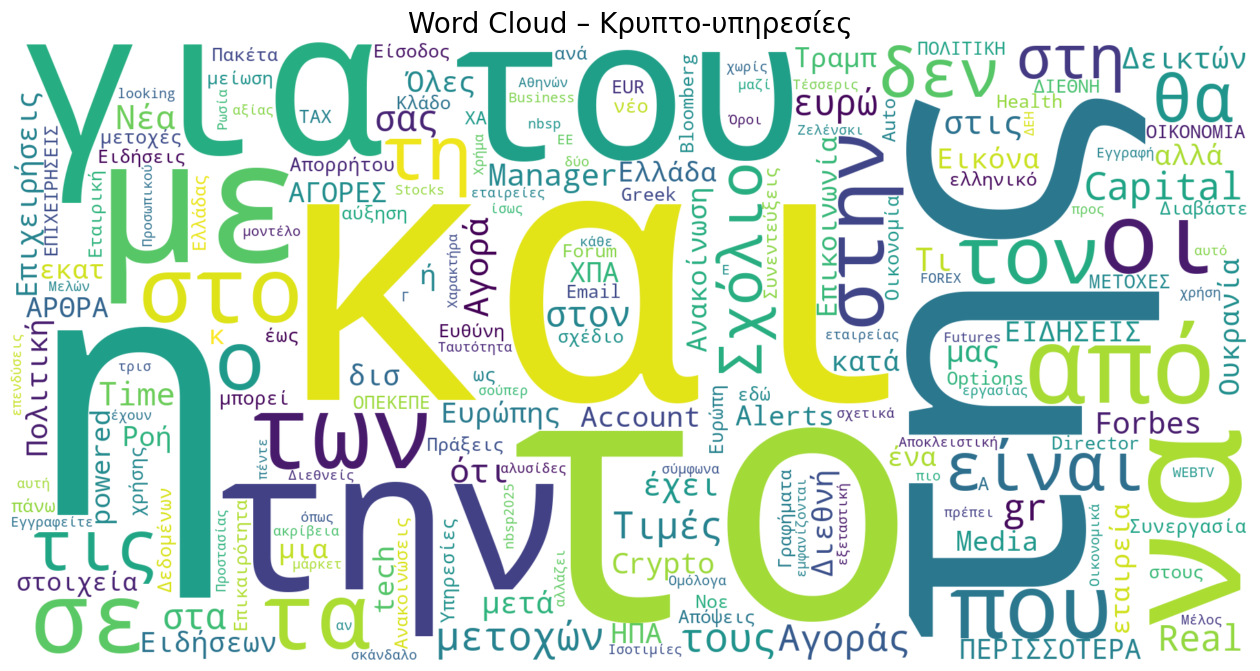

In [68]:
def category_wordcloud(category, df):
    cat_terms = categories[category]
    relevant_texts = []

    for text in df["text"]:
        # Preprocess only once
        normalized_text, words, lemmas = preprocess_text(text)

        # Match category terms
        if any(match_term(term, normalized_text, words, lemmas) for term in cat_terms):
            relevant_texts.append(text)

    if not relevant_texts:
        print(f"Skipping category '{category}' – no matching texts found.")
        return

    combined = " ".join(relevant_texts)

    wc = WordCloud(
        width=1800,
        height=900,
        background_color="white",
        collocations=False,        # IMPORTANT: avoid merging multiword terms
        normalize_plurals=False,   # Greek plural handling is custom
    ).generate(combined)

    plt.figure(figsize=(16, 9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud – {category}", fontsize=20)
    plt.show()


# Run for each category
for cat in categories:
    category_wordcloud(cat, df)

#### Time Series Plot

C:\Users\dhanu\AppData\Local\Temp\ipykernel_19636\4175354389.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  expanded["timestamp"] = pd.to_datetime(expanded["timestamp"], errors="coerce")


<Figure size 1400x600 with 0 Axes>

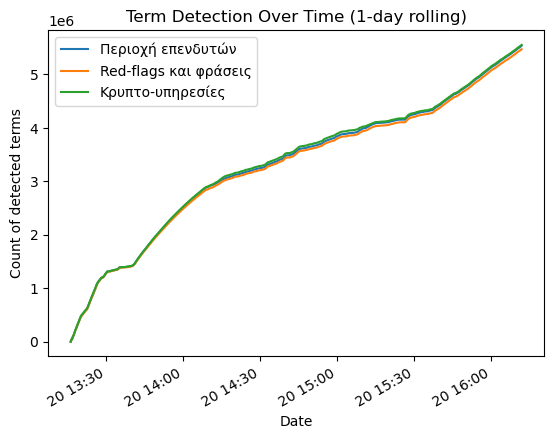

In [ ]:
# Load results
results_df = pd.read_pickle("results.pkl")

# Expand the 'counts' dictionary into separate columns
expanded = pd.concat(
    [results_df.drop(["counts"], axis=1),
     results_df["counts"].apply(pd.Series)],
    axis=1
)

# 1. Ensure timestamp is datetime
expanded["timestamp"] = pd.to_datetime(expanded["timestamp"], errors="coerce")

# Drop rows with invalid timestamps
expanded = expanded.dropna(subset=["timestamp"])


# 2. Add a formatted string version for export/display
expanded["timestamp_str"] = expanded["timestamp"].dt.strftime("%Y-%m-%d %H:%M:%S")


# 3. Identify numeric category columns
# Only include columns that exist and are numeric
category_cols = [c for c in expanded.columns if c not in ["url", "timestamp", "timestamp_str"]]

# Convert all category columns to numeric (safe for rolling sum)
expanded[category_cols] = expanded[category_cols].apply(pd.to_numeric, errors="coerce").fillna(0)


# 4. Plot 1-day rolling sums
plt.figure(figsize=(14,6))
expanded.set_index("timestamp")[category_cols].rolling("1D").sum().plot()
plt.title("Term Detection Over Time (1-day rolling)")
plt.ylabel("Count of detected terms")
plt.xlabel("Date")
plt.show()


# 5. save cleaned DataFrame
expanded.to_csv("expanded_results.csv", index=False)

#### Heatmap for Top Categories

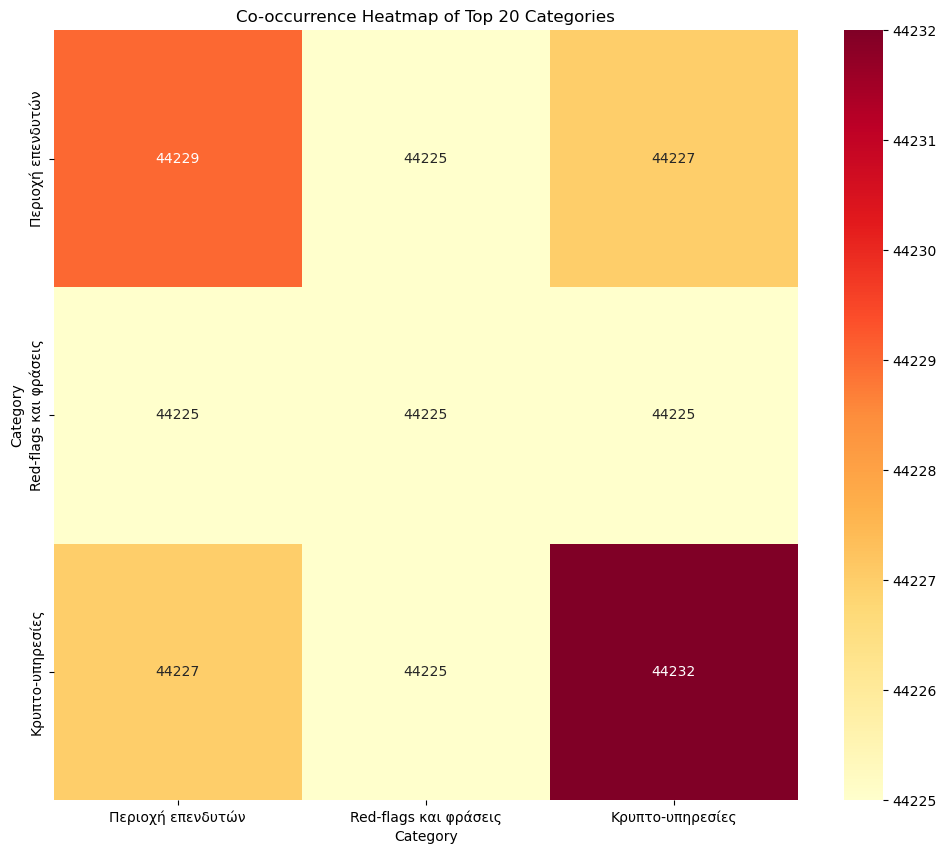

In [ ]:
# 1) Prepare category list
cat_list = list(results_df["counts"].iloc[0].keys())


# 2) Build co-occurrence matrix
co_matrix = np.zeros((len(cat_list), len(cat_list)), dtype=int)

for _, row in results_df.iterrows():
    detected = row["counts"]  # dict: {category: n_hits}
    hits = [i for i, c in enumerate(cat_list) if detected.get(c, 0) > 0]

    for i in hits:
        for j in hits:
            co_matrix[i][j] += 1


# 3) Select top N categories to avoid huge matrix
total_counts = np.array([sum(row.get(c, 0) for _, row in results_df.iterrows()) for c in cat_list])
N = 20  # top N categories
top_idx = np.argsort(-total_counts)[:N]

co_matrix_small = co_matrix[np.ix_(top_idx, top_idx)]
cat_list_small = [cat_list[i] for i in top_idx]


# 4) Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_matrix_small, annot=True, fmt="d",
            xticklabels=cat_list_small, yticklabels=cat_list_small,
            cmap="YlOrRd")
plt.title(f"Co-occurrence Heatmap of Top {N} Categories")
plt.ylabel("Category")
plt.xlabel("Category")
plt.show()


#### Hourly Average plot

C:\Users\dhanu\AppData\Local\Temp\ipykernel_19636\1128683793.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = df.resample('H')[['Περιοχή επενδυτών', 'Red-flags και φράσεις', 'Κρυπτο-υπηρεσίες']].mean()


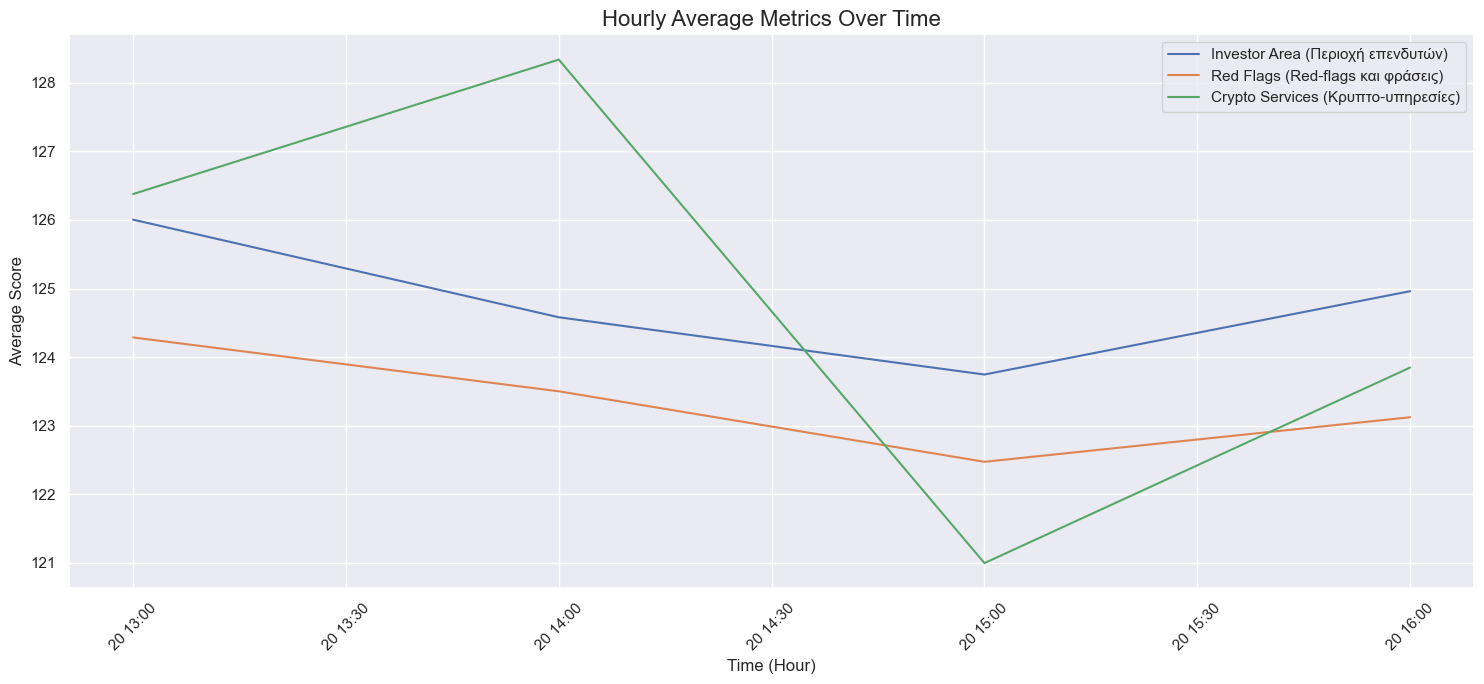

In [ ]:
df = pd.read_csv('expanded_results.csv')

# Convert the 'timestamp' column to actual datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the timestamp as the index
df.set_index('timestamp', inplace=True)

# 3. Resample by Hour
hourly_data = df.resample('H')[['Περιοχή επενδυτών', 'Red-flags και φράσεις', 'Κρυπτο-υπηρεσίες']].mean()

# Reset index to make 'timestamp' a column again for plotting
hourly_data = hourly_data.reset_index()

# 4. Visualization
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 7))

# Plot each metric
sns.lineplot(data=hourly_data, x='timestamp', y='Περιοχή επενδυτών', label='Investor Area (Περιοχή επενδυτών)')
sns.lineplot(data=hourly_data, x='timestamp', y='Red-flags και φράσεις', label='Red Flags (Red-flags και φράσεις)')
sns.lineplot(data=hourly_data, x='timestamp', y='Κρυπτο-υπηρεσίες', label='Crypto Services (Κρυπτο-υπηρεσίες)')

# Formatting the chart
plt.title('Hourly Average Metrics Over Time', fontsize=16)
plt.xlabel('Time (Hour)', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [116]:
df = pd.read_csv('expanded_results.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
sns.set_theme(style="darkgrid")

#### Smoothed Average Trend for Red flags vs. Investor area

C:\Users\dhanu\AppData\Local\Temp\ipykernel_19636\3505229278.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_df = df.rolling(window='4H').mean(numeric_only=True)


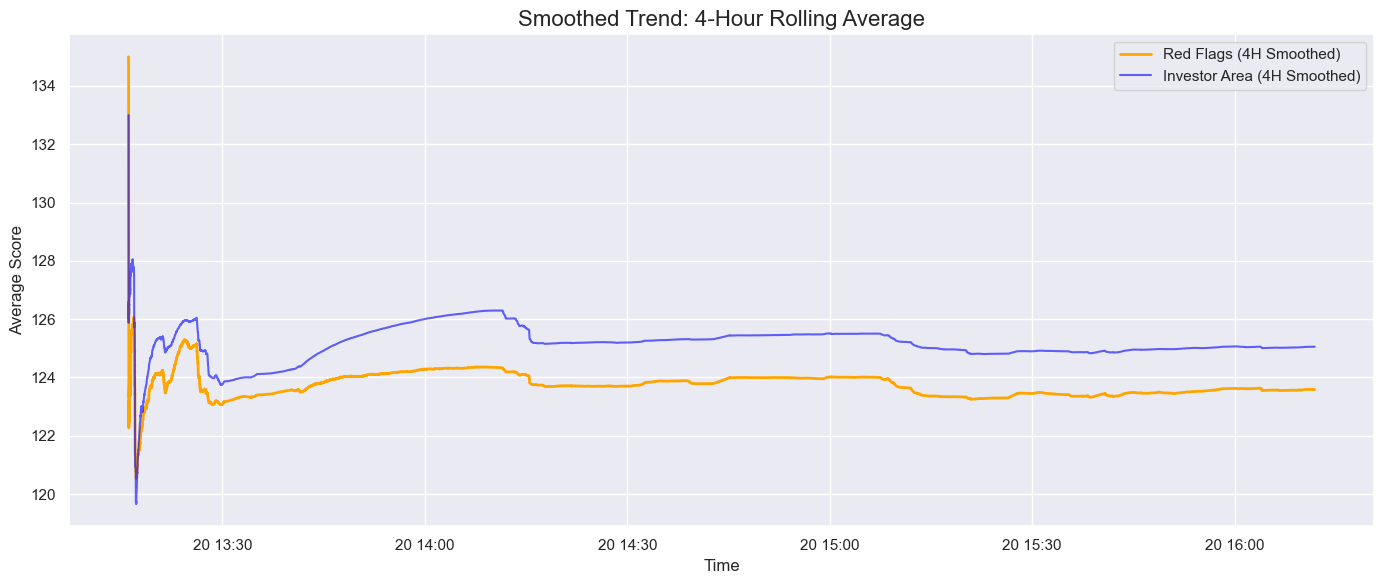

In [ ]:
# Smoothed Trend (Rolling Average)
plt.figure(figsize=(14, 6))

# FIX: Added numeric_only=True to ignore the URL column
rolling_df = df.rolling(window='4H').mean(numeric_only=True)

sns.lineplot(data=rolling_df, x=rolling_df.index, y='Red-flags και φράσεις', 
             label='Red Flags (4H Smoothed)', color='orange', linewidth=2)
sns.lineplot(data=rolling_df, x=rolling_df.index, y='Περιοχή επενδυτών', 
             label='Investor Area (4H Smoothed)', color='blue', alpha=0.6)

plt.title('Smoothed Trend: 4-Hour Rolling Average', fontsize=16)
plt.ylabel('Average Score')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

#### Red Flags Heatmap

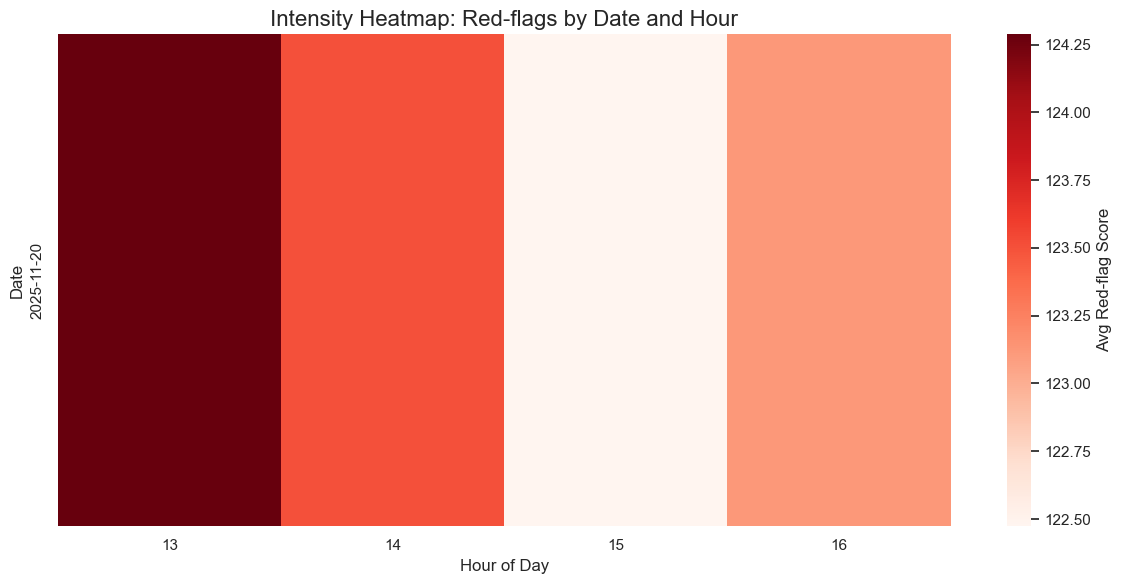

In [120]:
plt.figure(figsize=(12, 6))
df_heatmap = df.copy()
df_heatmap['date'] = df_heatmap.index.date
df_heatmap['hour'] = df_heatmap.index.hour

# Pivot the data: Rows=Date, Cols=Hour, Values=Mean Score
heatmap_data = df_heatmap.pivot_table(index='date', columns='hour', 
                                      values='Red-flags και φράσεις', aggfunc='mean')

sns.heatmap(heatmap_data, cmap='Reds', annot=False, cbar_kws={'label': 'Avg Red-flag Score'})
plt.title('Intensity Heatmap: Red-flags by Date and Hour', fontsize=16)
plt.ylabel('Date')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.show()

#### Volatility Over time

This plot shows how much the metric (in this case, Red-flags και φράσεις) fluctuates over 1-hour windows

C:\Users\dhanu\AppData\Local\Temp\ipykernel_19636\3251349704.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  volatility_df = df.rolling(window='1H').std(numeric_only=True)


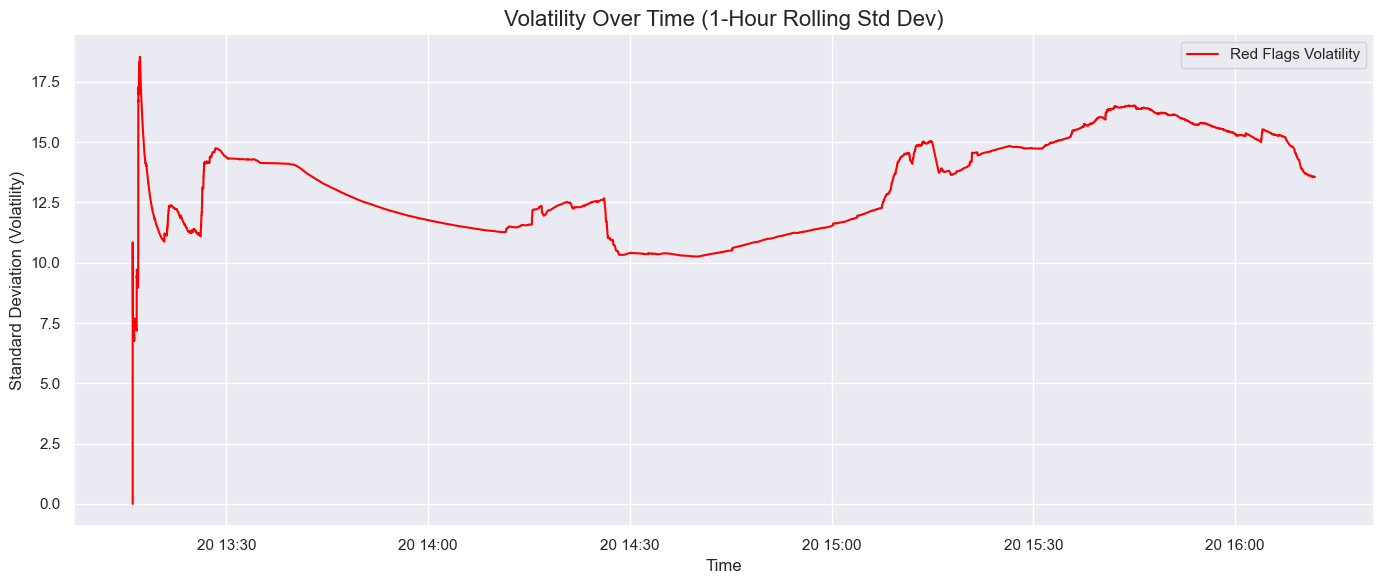

In [130]:
# --- Visualization 3: Volatility (Rolling Standard Deviation) ---
plt.figure(figsize=(14, 6))

# 1. Calculate Volatility
volatility_df = df.rolling(window='1H').std(numeric_only=True)

# 2. FIX: Reset index to handle duplicate timestamps
# This moves 'timestamp' from the index to a regular column
volatility_plot_data = volatility_df.reset_index()

# 3. Plot using the new dataframe and explicit column names
sns.lineplot(data=volatility_plot_data, x='timestamp', y='Red-flags και φράσεις', 
             label='Red Flags Volatility', color='red')

plt.title('Volatility Over Time (1-Hour Rolling Std Dev)', fontsize=16)
plt.ylabel('Standard Deviation (Volatility)')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

#### Other Possible Visualizations

C:\Users\dhanu\AppData\Local\Temp\ipykernel_19636\4015817307.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_risk_domains, x='Red-flags και φράσεις', y='domain', palette='Reds_r')


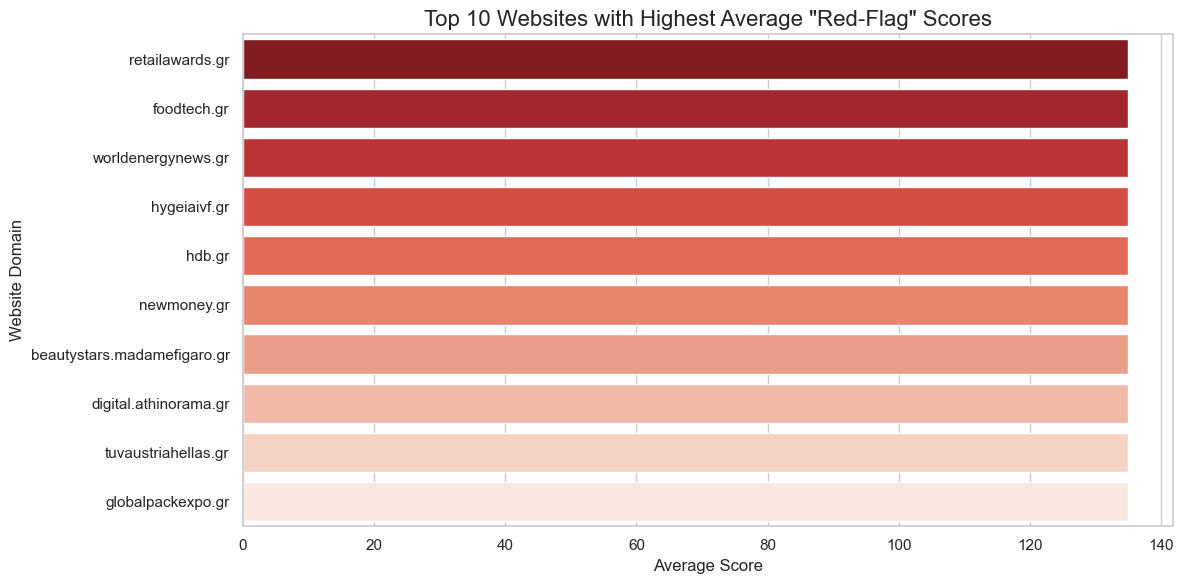

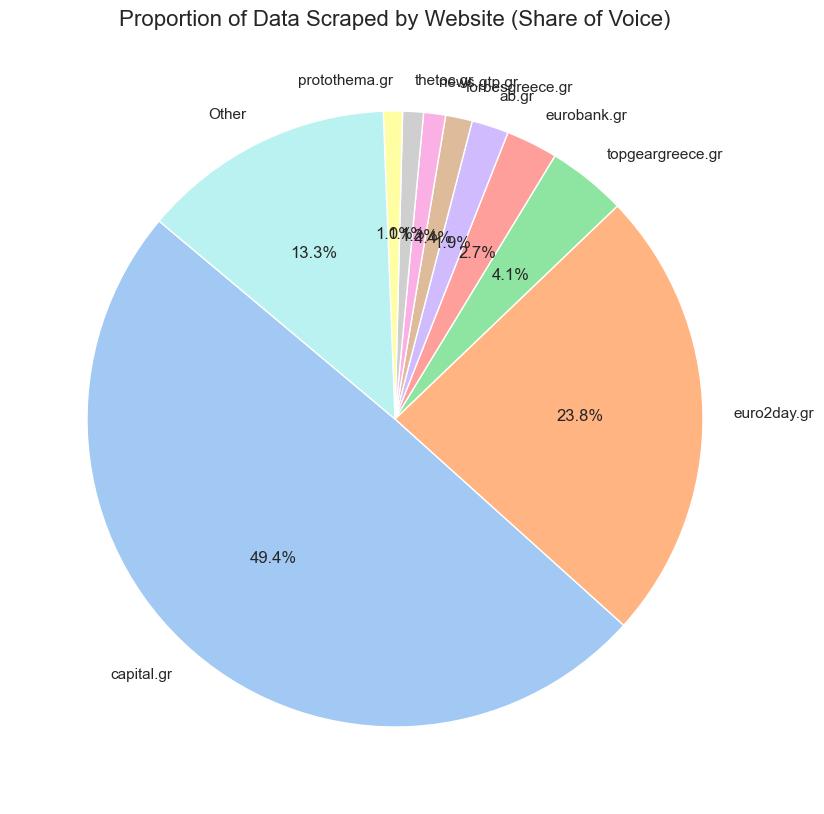

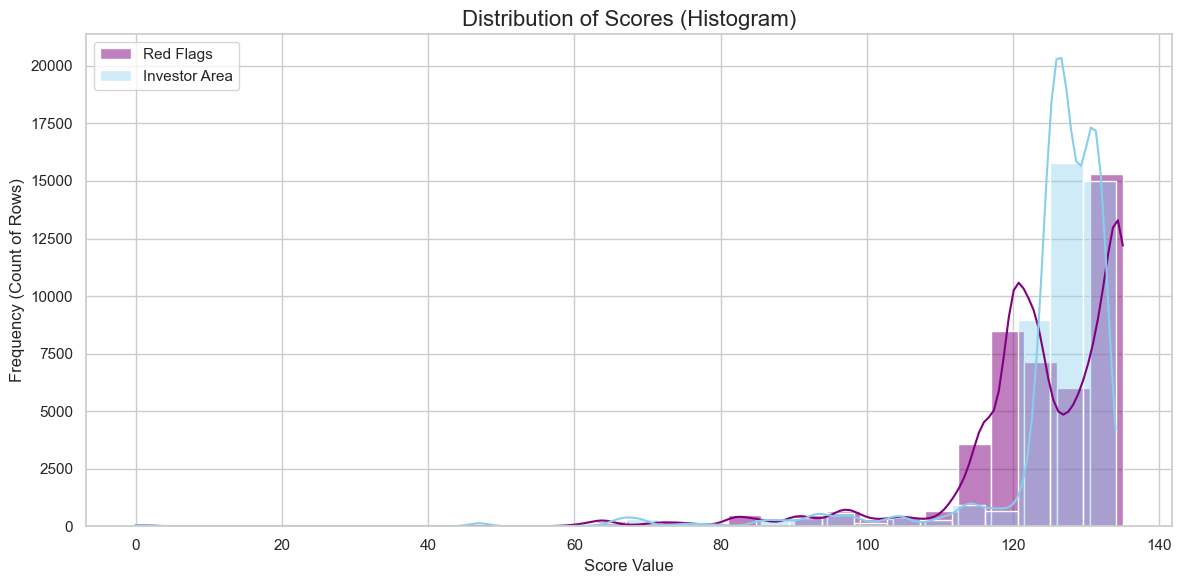

In [ ]:
from urllib.parse import urlparse

# extract the "Domain" from the url
def get_domain(url):
    try:
        return urlparse(str(url)).netloc.replace('www.', '')
    except:
        return 'unknown'

df['domain'] = df['url'].apply(get_domain)

sns.set_theme(style="whitegrid")

# 1: Bar Chart (Top 10 Domains by Avg Red-Flag Score)
plt.figure(figsize=(12, 6))

top_risk_domains = df.groupby('domain')['Red-flags και φράσεις'].mean().sort_values(ascending=False).head(10).reset_index()

sns.barplot(data=top_risk_domains, x='Red-flags και φράσεις', y='domain', palette='Reds_r')

plt.title('Top 10 Websites with Highest Average "Red-Flag" Scores', fontsize=16)
plt.xlabel('Average Score', fontsize=12)
plt.ylabel('Website Domain', fontsize=12)
plt.tight_layout()
plt.show()

# 2: Pie Chart (Share of Voice / Volume)
plt.figure(figsize=(10, 10))

domain_counts = df['domain'].value_counts()

if len(domain_counts) > 10:
    top_domains = domain_counts.head(9)
    other_count = domain_counts.iloc[9:].sum()
    top_domains['Other'] = other_count
else:
    top_domains = domain_counts

plt.pie(top_domains, labels=top_domains.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Proportion of Data Scraped by Website (Share of Voice)', fontsize=16)
plt.show()

# 3: Histogram (Distribution of Scores)
plt.figure(figsize=(12, 6))

sns.histplot(df['Red-flags και φράσεις'], bins=30, kde=True, color='purple', label='Red Flags')
sns.histplot(df['Περιοχή επενδυτών'], bins=30, kde=True, color='skyblue', label='Investor Area', alpha=0.4)

plt.title('Distribution of Scores (Histogram)', fontsize=16)
plt.xlabel('Score Value', fontsize=12)
plt.ylabel('Frequency (Count of Rows)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()